In [47]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from torch.nn.utils.rnn import pad_sequence
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence


import torch.optim as optim
from sklearn.model_selection import KFold

import pyswarms as pso

import seaborn as sns
# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [25]:
def load_data(file_names):
    dataframes = []
    for idx, file_name in enumerate(file_names):
        df = pd.read_csv(file_name)
        df['id'] = idx  # Add a unique identifier for each sequence
        dataframes.append(df)
    # Data processing

    return pd.concat(dataframes, axis=0)

def plot_data(df,index):
    data = df[df["id"] == index]
    fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12, 7))

    # Temperature Plot
    temperature_columns = list(data.columns)[0:13]  # Adjust this based on your actual temperature columns
    data[temperature_columns].plot(ax=axes[0])
    axes[0].set_xlabel('Time (seconds)')
    axes[0].set_ylabel('Temperature (°C)')
    axes[0].set_title('Temperature at Different Measurement Points')

    # Reference Current Plot
    data[['IdRef', 'IqRef']].plot(ax=axes[1])
    axes[1].set_xlabel('Time (seconds)')
    axes[1].set_ylabel('Current (A)')
    axes[1].set_title('Reference Current (IdRef and IqRef)')

    # Speed and Torque Plot
    ax_speed_torque = axes[2]
    ax_torque = ax_speed_torque.twinx()
    data['speed'].plot(ax=ax_speed_torque, color='blue', label='Speed')
    data['Torque'].plot(ax=ax_torque, color='green', label='Torque')
    ax_speed_torque.set_xlabel('Time (seconds)')
    ax_speed_torque.set_ylabel('Speed', color='blue')
    ax_torque.set_ylabel('Torque', color='green')
    ax_speed_torque.set_title('Operation Speed and Torque')
    ax_speed_torque.legend(loc='upper left')
    ax_torque.legend(loc='upper right')

    # Power Plot
    data['Pele_PI'].plot(ax=axes[3])
    axes[3].set_xlabel('Time (seconds)')
    axes[3].set_ylabel('Power (W)')
    axes[3].set_title('Power of Controller (Pele_PI)')

    plt.tight_layout()
    plt.show()

In [26]:
def plot_3rdLPTN(df, index):
    data = df[df["id"] == index]
    
    # Create a figure with 3x2 subplots
    fig, axs = plt.subplots(3, 2, figsize=(12, 7))  # Adjust figsize as needed

    # Plot active_wind - Est and Mea
    axs[0, 0].plot(data['active_wind_est'], color=[0, 0, 1], label='Est - Active Wind')
    axs[0, 0].plot(data['active_wind'], color=[1, 0, 0], label='Mea - Active Wind')
    axs[0, 0].legend()
    axs[0, 0].set_title('Active Wind Temperature')

    # Plot active_wind - Difference
    axs[0, 1].plot(data['active_wind'] - data['active_wind_est'], label='Difference - Active Wind')
    axs[0, 1].legend()
    axs[0, 1].set_title('Difference in Active Wind Temperature')

    # Plot stator - Est and Mea
    axs[1, 0].plot(data['stator_est'], color=[0, 0, 1], label='Est - Stator')
    axs[1, 0].plot(data['stator'], color=[1, 0, 0], label='Mea - Stator')
    axs[1, 0].legend()
    axs[1, 0].set_title('Stator Temperature')

    # Plot stator - Difference
    axs[1, 1].plot(data['stator'] - data['stator_est'], label='Difference - Stator')
    axs[1, 1].legend()
    axs[1, 1].set_title('Difference in Stator Temperature')

    # Plot rotor - Est and Mea
    axs[2, 0].plot(data['rotor_est'], color=[0, 0, 1], label='Est - Rotor')
    axs[2, 0].plot(data['rotor'], color=[1, 0, 0], label='Mea - Rotor')
    axs[2, 0].legend()
    axs[2, 0].set_title('Rotor Temperature')

    # Plot rotor - Difference
    axs[2, 1].plot(data['rotor'] - data['rotor_est'], label='Difference - Rotor')
    axs[2, 1].legend()
    axs[2, 1].set_title('Difference in Rotor Temperature')

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()


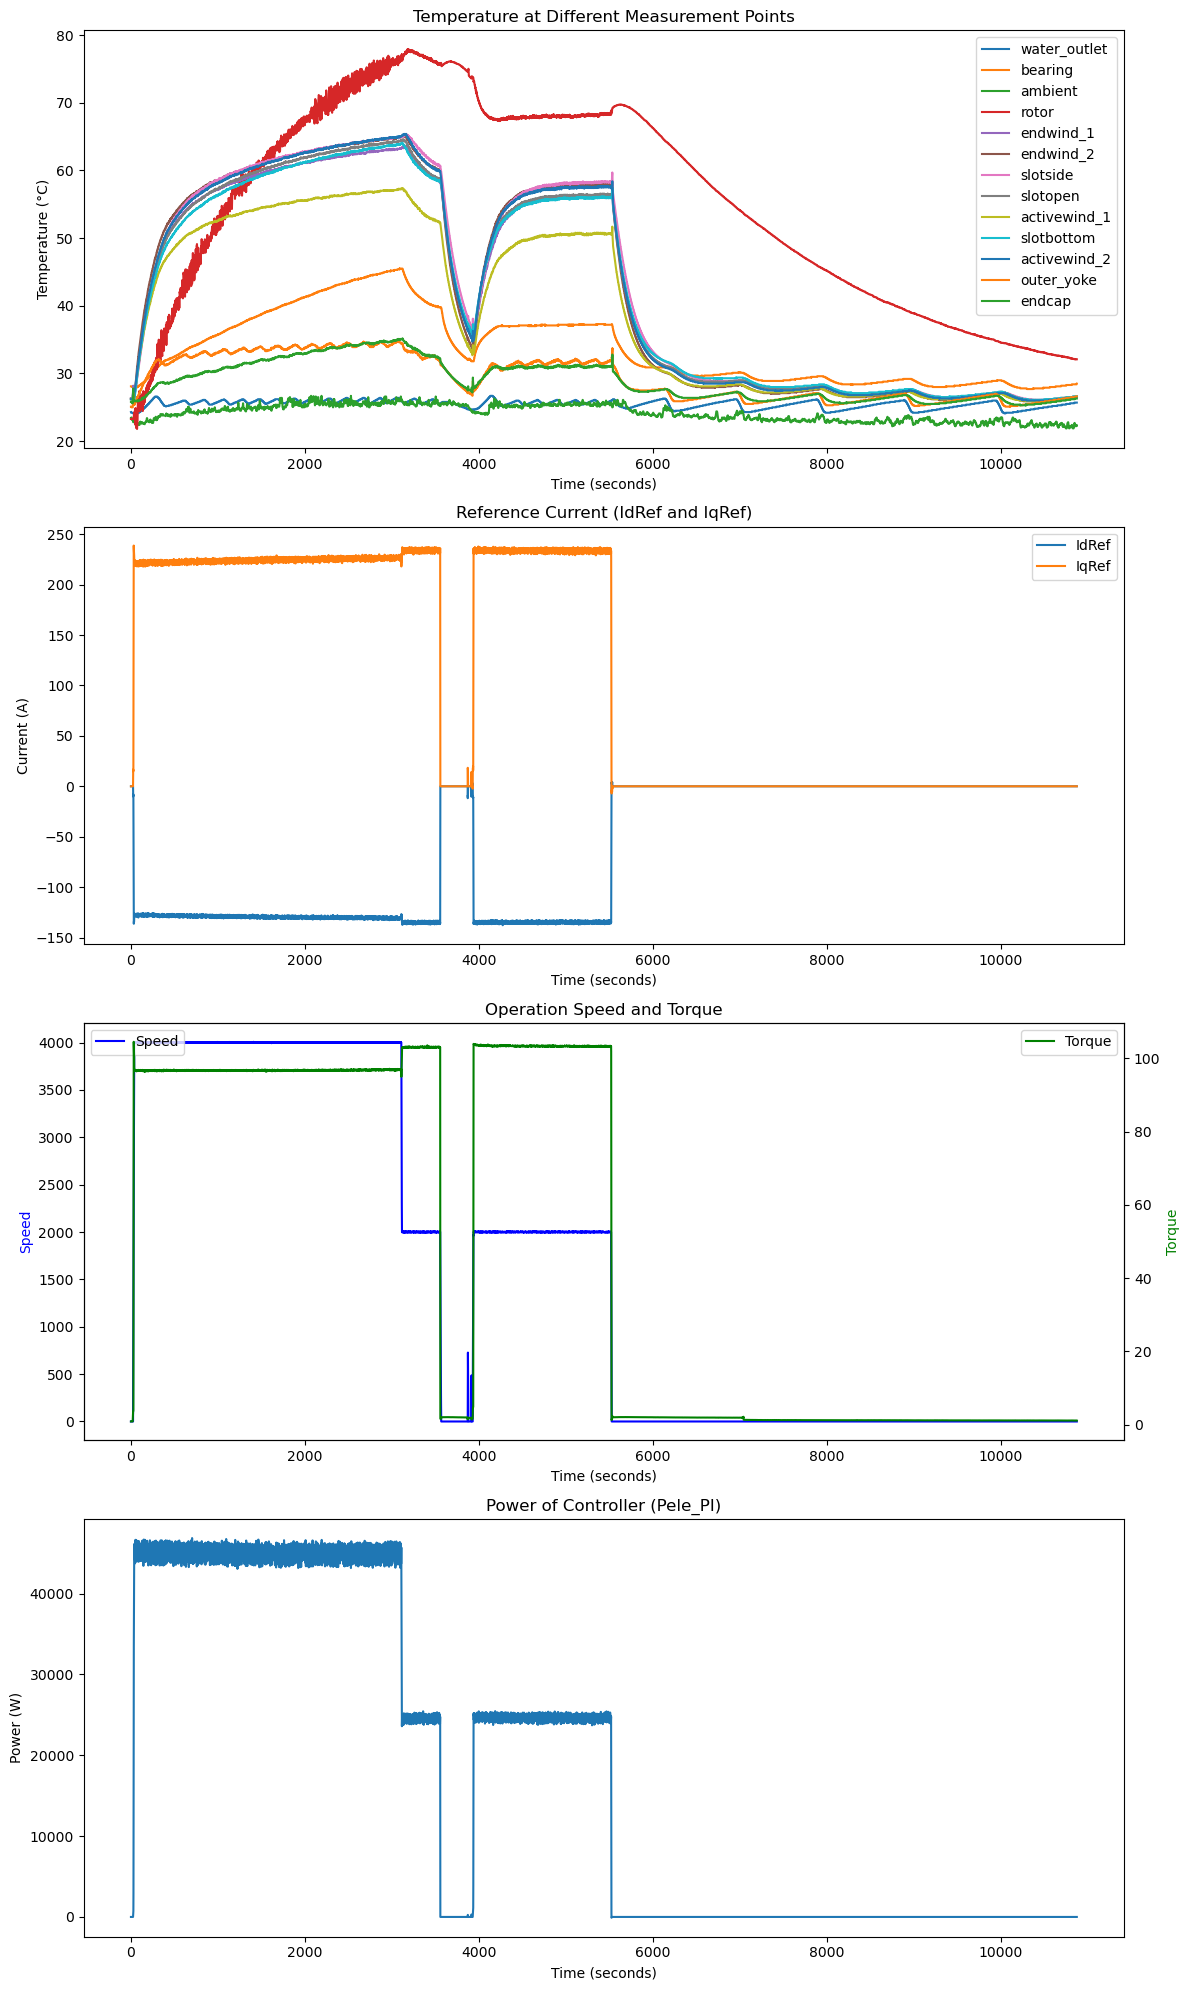

In [13]:
Path=os.path.dirname(os.getcwd())
file_names = [f"{Path}\dataset\id_{i}.csv" for i in range(16)]  # Update range to include id 0 to id 15
df = load_data(file_names)
df['active_wind'] = (df['activewind_1'] + df['activewind_2']) / 2
df['stator'] = (df['slotbottom'] + df['outer_yoke']) / 2
plot_data(df,4) # plot the temperature and states of specific id.

In [15]:
# Coefficients and parameters for the thermal model
G_s2r0 = 1/0.5769
alpha_s2r = - 0.7913 / 4000
R_s2r_res = 0.007967

G_r2a0 = 1/5.00
alpha_r2a = - 0.3128 / 4000
R_r2a_res = 0.0117

Rs = 4.67e-3
alpha_cu = 0.39 / 100
kcu_f1 = 0.02174
kcu_f2 = 0.38740

kres_i = 4.656e-6
kres_f = 247.8
kres_if = 1151.47

alpha_pres = 0.8910
alpha_pres_i = 0.0231
alpha_pres_f = -0.0397
alpha_pres_if = -0.009

G_w2s = 1/0.01375
G_s2c = 1/0.01879

C_w = 3716.15
C_s = 5616.32
C_r = 5329.69

# Construct the capacitance matrix and its inverse
C_hat = np.diag([C_w, C_s, C_r])
C_hat_inv = np.linalg.inv(C_hat)

# Time step for simulation
tsim = 1

# Initialize columns for estimated temperatures in your DataFrame
df['active_wind_est'] = np.nan
df['stator_est'] = np.nan
df['rotor_est'] = np.nan

# Loop over each unique 'id' in dataset
for idx in range(0,16):
    # Filter data for the current 'id'
    data = df[df["id"] == idx].copy()

    # Initialize temperature estimates with the first known temperatures
    # or can assume the initial temperature is equal to zhe room temperature
    T_hat = np.array([data['active_wind'].iloc[0], data['stator'].iloc[0], data['rotor'].iloc[0]])
    data.loc[0,'active_wind_est'] = data.loc[0,'active_wind']
    data.loc[0,'stator_est'] = data.loc[0,'stator']
    data.loc[0,'rotor_est'] =  data.loc[0,'rotor']

    # Loop over each time step in the data
    for i in range(1,len(data)):
        #scale the value of current and speed into 0~1
        is_ = np.sqrt(data['IdRef'].iloc[i]**2 + data['IqRef'].iloc[i]**2)/370
        f = data['speed'].iloc[i] / 4000
        
        #calculate the power loss of winding node
        p_w = is_**2 * 370 * 370 * 3/2 * Rs * (1 + alpha_cu * (data['active_wind_est'].iloc[i-1] - 20)) * (1 + kcu_f1 * f + kcu_f2 * f**2)
        #calculate the rest power losses based on the polynomial function fitted by matlab curve fitting tool.
        p_res = kres_i * is_ + kres_f * f + kres_if * is_ * f
        alpha = alpha_pres + alpha_pres_i * is_ + alpha_pres_f * f + alpha_pres_if * is_ * f
        alpha = np.clip(alpha, 0, 1)
        p_s = p_res * alpha
        p_r = p_res * (1 - alpha)
        P = np.array([p_w, p_s, p_r])

        #calculate the convection resistance
        R_s2r = 1 / G_s2r0 * np.exp(alpha_s2r * f) + R_s2r_res
        G_s2r = 1 / R_s2r
        R_r2a = 1 / G_r2a0 * np.exp(alpha_r2a * f) + R_r2a_res
        G_r2a = 1 / R_r2a

        G_hat = np.array([[-G_w2s, G_w2s, 0],
                        [G_w2s, -(G_w2s + G_s2r + G_s2c), G_s2r],
                        [0, G_s2r, -(G_s2r + G_r2a)]])

        Gac_hat = np.array([[0, G_s2c, 0], [0, 0, G_r2a]]).T
        # Update temperature estimates based on the calculated power losses and thermal model
        Tac = np.array([data['water_outlet'].iloc[i], data['ambient'].iloc[i]])
        dot_T_hat = np.dot(C_hat_inv, (np.dot(G_hat, T_hat) + P + np.dot(Gac_hat, Tac)))
        T_hat += dot_T_hat * tsim

        #store the updated temperature estimation in the dataframe for the later LSTM use
        data.loc[i,'active_wind_est'] = T_hat[0]
        data.loc[i,'stator_est'] = T_hat[1]
        data.loc[i,'rotor_est'] = T_hat[2]
    df[df["id"] == idx] = data.copy()

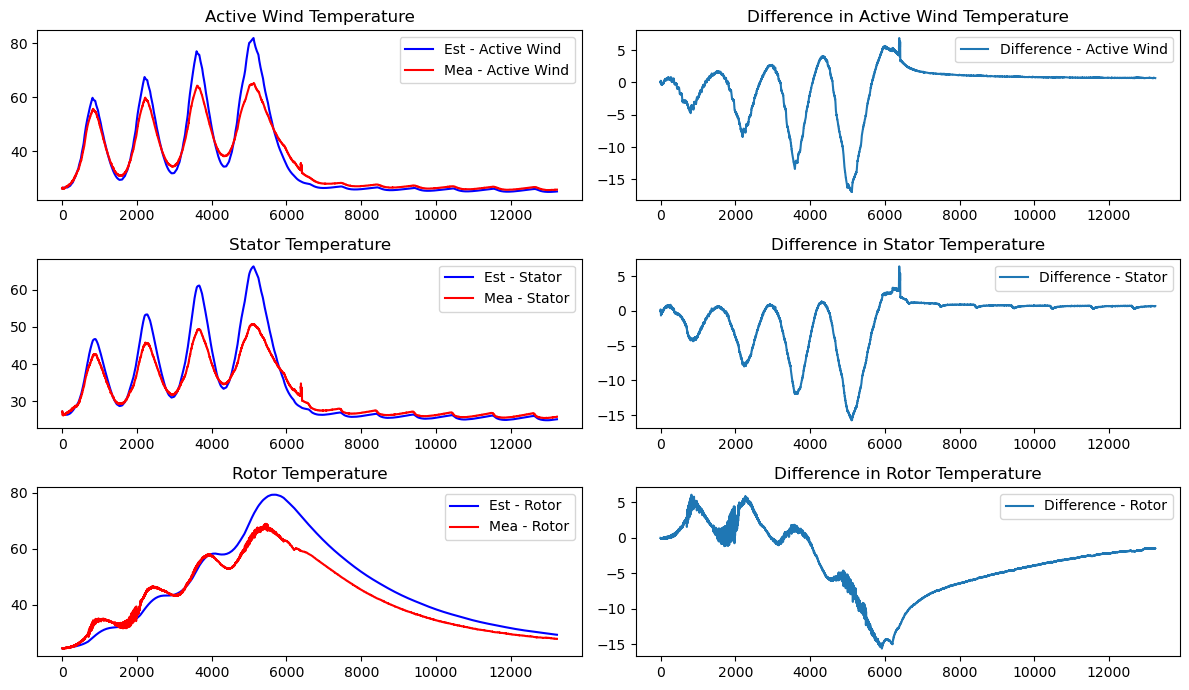

In [35]:
idx = 2
plot_3rdLPTN(df,idx)
# save the 3rd order LPTN output for the use in LSTM
df.to_csv(f"{Path}\\dataset\\temperature.csv")

This figure illustrates the comparison between estimated and measured temperatures during full-condition operation. While there is a consistent trend between the two, notable discrepancies still exist, indicating areas for improvement in estimation accuracy. Showing the drawbacks of low-order LPTN on temperature estimation.

In [37]:
df = pd.read_csv(f"{Path}\\dataset\\temperature.csv")
df.fillna(method='ffill', inplace=True)
print(np.any(df.isnull()))
df["is"] = (df["IdRef"]**2 + df["IdRef"]**2)**0.5
df["us"] = (df["Ud"]**2 + df["Uq"]**2)**0.5
df["endwind"] = (df["endwind_1"]+df["endwind_2"]) * 0.5
df = df.drop("Unnamed: 0",axis=1)
df.head(5)

False


,water_outlet,bearing,ambient,rotor,endwind_1,endwind_2,slotside,slotopen,activewind_1,slotbottom,...,Pele_PI,id,active_wind,stator,active_wind_est,stator_est,rotor_est,is,us,endwind
0,24.2,25.9,22.600000,25.875000,29.600000,28.400000,28.800000,27.200000,27.000000,26.600000,...,7.256534,0,26.900000,26.850000,26.900000,26.850000,25.875000,5.376851,1.969130,29.000000
1,24.2,25.9,22.600000,25.876250,29.550000,28.365000,28.775000,27.190000,26.995000,26.585000,...,10.474160,0,26.892500,26.832500,26.899262,26.825305,25.875199,1.729196,0.096676,28.957500
2,24.2,25.9,22.605000,25.878688,29.467500,28.296750,28.731250,27.170500,26.970250,26.545750,...,2.330034,0,26.867875,26.788375,26.898079,26.801290,25.875406,6.174336,0.635787,28.882125
3,24.2,25.9,22.609750,25.878503,29.344125,28.196912,28.664687,27.136975,26.936737,26.513462,...,1.035857,0,26.839481,26.756456,26.896220,26.777699,25.875592,3.021344,0.224602,28.770519
4,24.2,25.9,22.619263,25.878328,29.201919,28.092067,28.601453,27.110126,26.914901,26.482789,...,5.491970,0,26.820007,26.723633,26.894037,26.754630,25.875772,4.106945,0.860758,28.646993


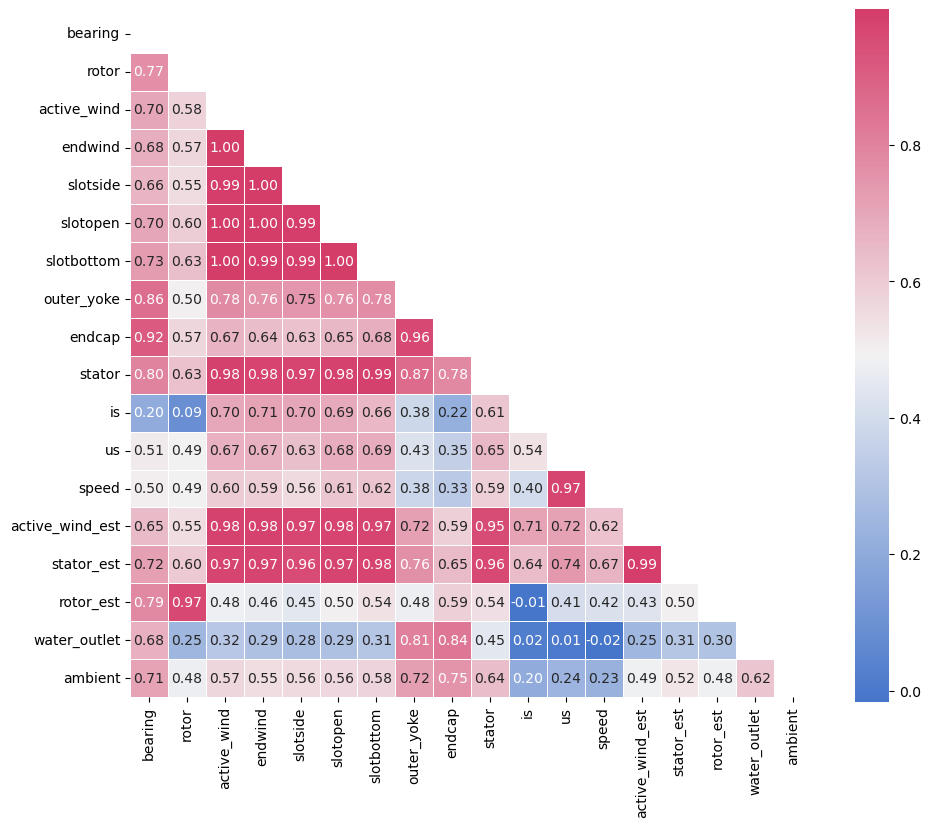

The total id profiles are[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
the train profiles for LSTM are[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13]
the test profiles for LSTM are[6, 15]


In [41]:
target_cols = ["bearing","rotor","active_wind","endwind","slotside","slotopen","slotbottom","outer_yoke","endcap","stator"]
# target_cols = ["rotor","active_wind","endwind","slotside","slotopen","slotbottom"]
inputs_cols = ["is","us","speed","active_wind_est","stator_est","rotor_est","water_outlet","ambient"]
id_profiles = [p for p in df.id.unique()]
test_profiles = [6,15]
train_profiles = [p for p in df.id.unique() if p not in test_profiles + [14]]

df_corr = df[target_cols + inputs_cols]
corr = df_corr.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, annot=True, linewidths=.5, fmt='.2f', 
            cmap=sns.diverging_palette(255, 0, as_cmap=True), 
            square=True, ax=ax)

plt.show()

print(f"The total id profiles are{id_profiles}")
print(f"the train profiles for LSTM are{train_profiles}")
print(f"the test profiles for LSTM are{test_profiles}")

In [42]:
# Create a copy of the DataFrame to preserve the original data
df_norm = df.copy()

# Calculate the global minimum and maximum values for input columns
global_min_inputs = df_norm[inputs_cols].min()
global_max_inputs = df_norm[inputs_cols].max()

# Calculate the global minimum and maximum values for target columns
global_min_target = df_norm[target_cols].min()
global_max_target = df_norm[target_cols].max()

# Normalize input columns to be in the range [-1, 1]
df_norm.loc[:,inputs_cols] = ((df_norm.loc[:,inputs_cols] - global_min_inputs)/(global_max_inputs - global_min_inputs) - 0.5) * 2
# Normalize target columns to be in the range [-1, 1]
df_norm.loc[:,target_cols] = ((df_norm.loc[:,target_cols] - global_min_target)/(global_max_target - global_min_target) - 0.5) * 2

# Alternative normalization (commented out) - normalizes data to [0, 1] range
# df_norm.loc[:,inputs_cols] = ((df_norm.loc[:,inputs_cols] - global_min_inputs)/(global_max_inputs - global_min_inputs))
# df_norm.loc[:,target_cols] = ((df_norm.loc[:,target_cols] - global_min_target)/(global_max_target - global_min_target))

# Display the first 5 rows of the normalized DataFrame
df_norm.head(5)

,water_outlet,bearing,ambient,rotor,endwind_1,endwind_2,slotside,slotopen,activewind_1,slotbottom,...,Pele_PI,id,active_wind,stator,active_wind_est,stator_est,rotor_est,is,us,endwind
0,0.331276,-0.496183,-0.060000,-0.761099,29.600000,28.400000,-0.651838,-0.682281,27.000000,-0.695560,...,7.256534,0,-0.651398,-0.545383,-0.780038,-0.707517,-0.815617,-0.961558,-0.992319,-0.632047
1,0.331276,-0.496183,-0.060000,-0.761056,29.550000,28.365000,-0.652805,-0.682688,26.995000,-0.696195,...,10.474160,0,-0.651720,-0.546514,-0.780059,-0.708548,-0.815612,-0.987637,-0.999628,-0.633729
2,0.331276,-0.496183,-0.059000,-0.760974,29.467500,28.296750,-0.654497,-0.683483,26.970250,-0.697854,...,2.330034,0,-0.652776,-0.549368,-0.780094,-0.709551,-0.815606,-0.955856,-0.997524,-0.636711
3,0.331276,-0.496183,-0.058050,-0.760980,29.344125,28.196912,-0.657072,-0.684848,26.936737,-0.699219,...,1.035857,0,-0.653994,-0.551431,-0.780148,-0.710537,-0.815601,-0.978399,-0.999129,-0.641127
4,0.331276,-0.496183,-0.056147,-0.760986,29.201919,28.092067,-0.659518,-0.685942,26.914901,-0.700516,...,5.491970,0,-0.654829,-0.553554,-0.780212,-0.711500,-0.815597,-0.970637,-0.996646,-0.646014


In [48]:
class CustomLSTMDataset(torch.utils.data.Dataset):
    """
    A custom dataset class for loading different lengtn time series data into an LSTM model.
    """
    def __init__(self, df, id_list, input_cols, target_cols,device):
        """
        Initialize the dataset with a DataFrame, list of IDs, input columns, target columns, and device.

        Parameters:
        df (DataFrame): The DataFrame containing the dataset.
        id_list (list): A list of unique identifiers to segment the DataFrame.
        input_cols (list): List of column names to be used as inputs.
        target_cols (list): List of column names to be used as targets.
        device (torch.device): The device (CPU or GPU) where tensors will be allocated.
        """
        self.inputs = []
        self.targets = []
        self.ids = []
        self.lengths = []

        # Iterate over each ID and extract the corresponding data
        for id_val in id_list:
            df_id = df[df['id'] == id_val]
            self.inputs.append(torch.tensor(df_id[input_cols].values, dtype=torch.float32).to(device))
            self.targets.append(torch.tensor(df_id[target_cols].values, dtype=torch.float32).to(device))
            self.ids.append(id_val)
            self.lengths.append(len(df_id))

    def __getitem__(self, index):
        """
        Get a single item from the dataset.

        Parameters:
        index (int): The index of the item to retrieve.

        Returns:
        tuple: A tuple containing the inputs and targets for the given index.
        """
        # return self.inputs[index], self.targets[index], self.ids[index], self.lengths[index]
        return self.inputs[index], self.targets[index]

    def __len__(self):
        """
        Get the total number of items in the dataset.

        Returns:
        int: The size of the dataset.
        """
        return len(self.inputs)


def collate_fn(batch):
    """
    Custom collate function for handling batches of variable-length sequences.

    Parameters:
    batch (list of tuples): A list where each tuple contains a sequence of inputs and targets.

    Returns:
    tuple: A tuple containing padded inputs, padded targets, and lengths of original sequences.
    """

    # Unzip the batch to separate inputs and targets
    inputs, targets = zip(*batch)

    # Calculate the lengths of each sequence in the batch
    lengths = torch.tensor([len(input) for input in inputs])

    # Padding sequences with 0
    # pad_sequence pads sequences to the length of the longest sequence in the batch
    # batch_first=True makes the batch dimension to be the first dimension (batch_size, seq_len, features)
    inputs_padded = pad_sequence(inputs, batch_first=True, padding_value=0)
    targets_padded = pad_sequence(targets, batch_first=True, padding_value=0)

    # Return the padded inputs, targets and the original lengths of the sequences
    return inputs_padded, targets_padded, lengths

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers,dropout_rate):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        self.dropout = nn.Dropout(dropout_rate)
        
        self.fc = nn.Linear(hidden_dim, output_dim)
        # self.nonlinear = nn.Tanh(hidden_dim,output_dim)
        for p in self.lstm.parameters():
            nn.init.normal_(p,mean=0.0,std=0.001)

    def forward(self, x, lengths):
        # Pack the sequence
        # lengths_cpu = lengths.cpu()
        x_packed = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)

        # Forward propagate LSTM
        packed_output, (hidden, cell) = self.lstm(x_packed)

        # Unpack the sequence
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        output = self.dropout(output)

        # You may want to use only the output of the last time step
        # For simplicity, let's apply the fully connected layer to all time steps
        output = self.fc(output)

        for i in range(len(lengths)):
            seq_len = lengths[i]
            output[i, :seq_len, 1] = output[i, :seq_len, 1] + x[i, :seq_len, 5]
            output[i, :seq_len, 2] = output[i, :seq_len, 2] + x[i, :seq_len, 3]
            output[i, :seq_len, 9] = output[i, :seq_len, 9] + x[i, :seq_len, 4]


        return output

In [49]:
# Create instances of the dataset for training and testing
train_dataset = CustomLSTMDataset(df_norm, train_profiles, inputs_cols, target_cols,device)
test_dataset  = CustomLSTMDataset(df_norm, test_profiles, inputs_cols, target_cols,device)

In [58]:
# Model parameters (you may need to adjust these)
input_dim = 8  # Number of input features
hidden_dim = 20  # Number of hidden layers
output_dim = 10  # Number of output features
num_layers = 1  # Number of LSTM layers
initial_learning_rate = 0.00928
lr_decay_factor = 0.986
epochs = 200
batch_size = 1
lambda2_reg = 0.00440
dropout_rate = 0.485
model = LSTMModel(input_dim, hidden_dim, output_dim, num_layers, dropout_rate).to(device)
criterion = nn.MSELoss()
optimizer = optim.NAdam(model.parameters(), lr=initial_learning_rate,weight_decay=lambda2_reg)

scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=lr_decay_factor)
train_loader = DataLoader(dataset = train_dataset,batch_size = batch_size,shuffle = True,num_workers=0,collate_fn=collate_fn)
for epoch in range(epochs):
    epoch_loss = 0
    model.train()
    for idx, (inputs, targets, lengths) in enumerate(train_loader):
        # Forward pass
        outputs = model(inputs, lengths)
        # Compute the loss
        loss = criterion(outputs, targets)
        epoch_loss += loss.item()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    scheduler.step()
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}, Average Loss: {epoch_loss / len(train_loader)}")

Epoch 10, Average Loss: 0.02516632154583931
Epoch 20, Average Loss: 0.02337532898840996
Epoch 30, Average Loss: 0.023618294570881587
Epoch 40, Average Loss: 0.021493233238848355
Epoch 50, Average Loss: 0.021294209389732435
Epoch 60, Average Loss: 0.021121670563633625
Epoch 70, Average Loss: 0.02016155543522193
Epoch 80, Average Loss: 0.02074262757713978
Epoch 90, Average Loss: 0.020137564422419436
Epoch 100, Average Loss: 0.019684248317319613
Epoch 110, Average Loss: 0.020044640064812623
Epoch 120, Average Loss: 0.01997974357352807
Epoch 130, Average Loss: 0.019523967129106704
Epoch 140, Average Loss: 0.019579277087289553
Epoch 150, Average Loss: 0.01933660487142893
Epoch 160, Average Loss: 0.01946036546276166
Epoch 170, Average Loss: 0.019336331707353775
Epoch 180, Average Loss: 0.01907233979839545
Epoch 190, Average Loss: 0.019203065966184322
Epoch 200, Average Loss: 0.018954945155061208


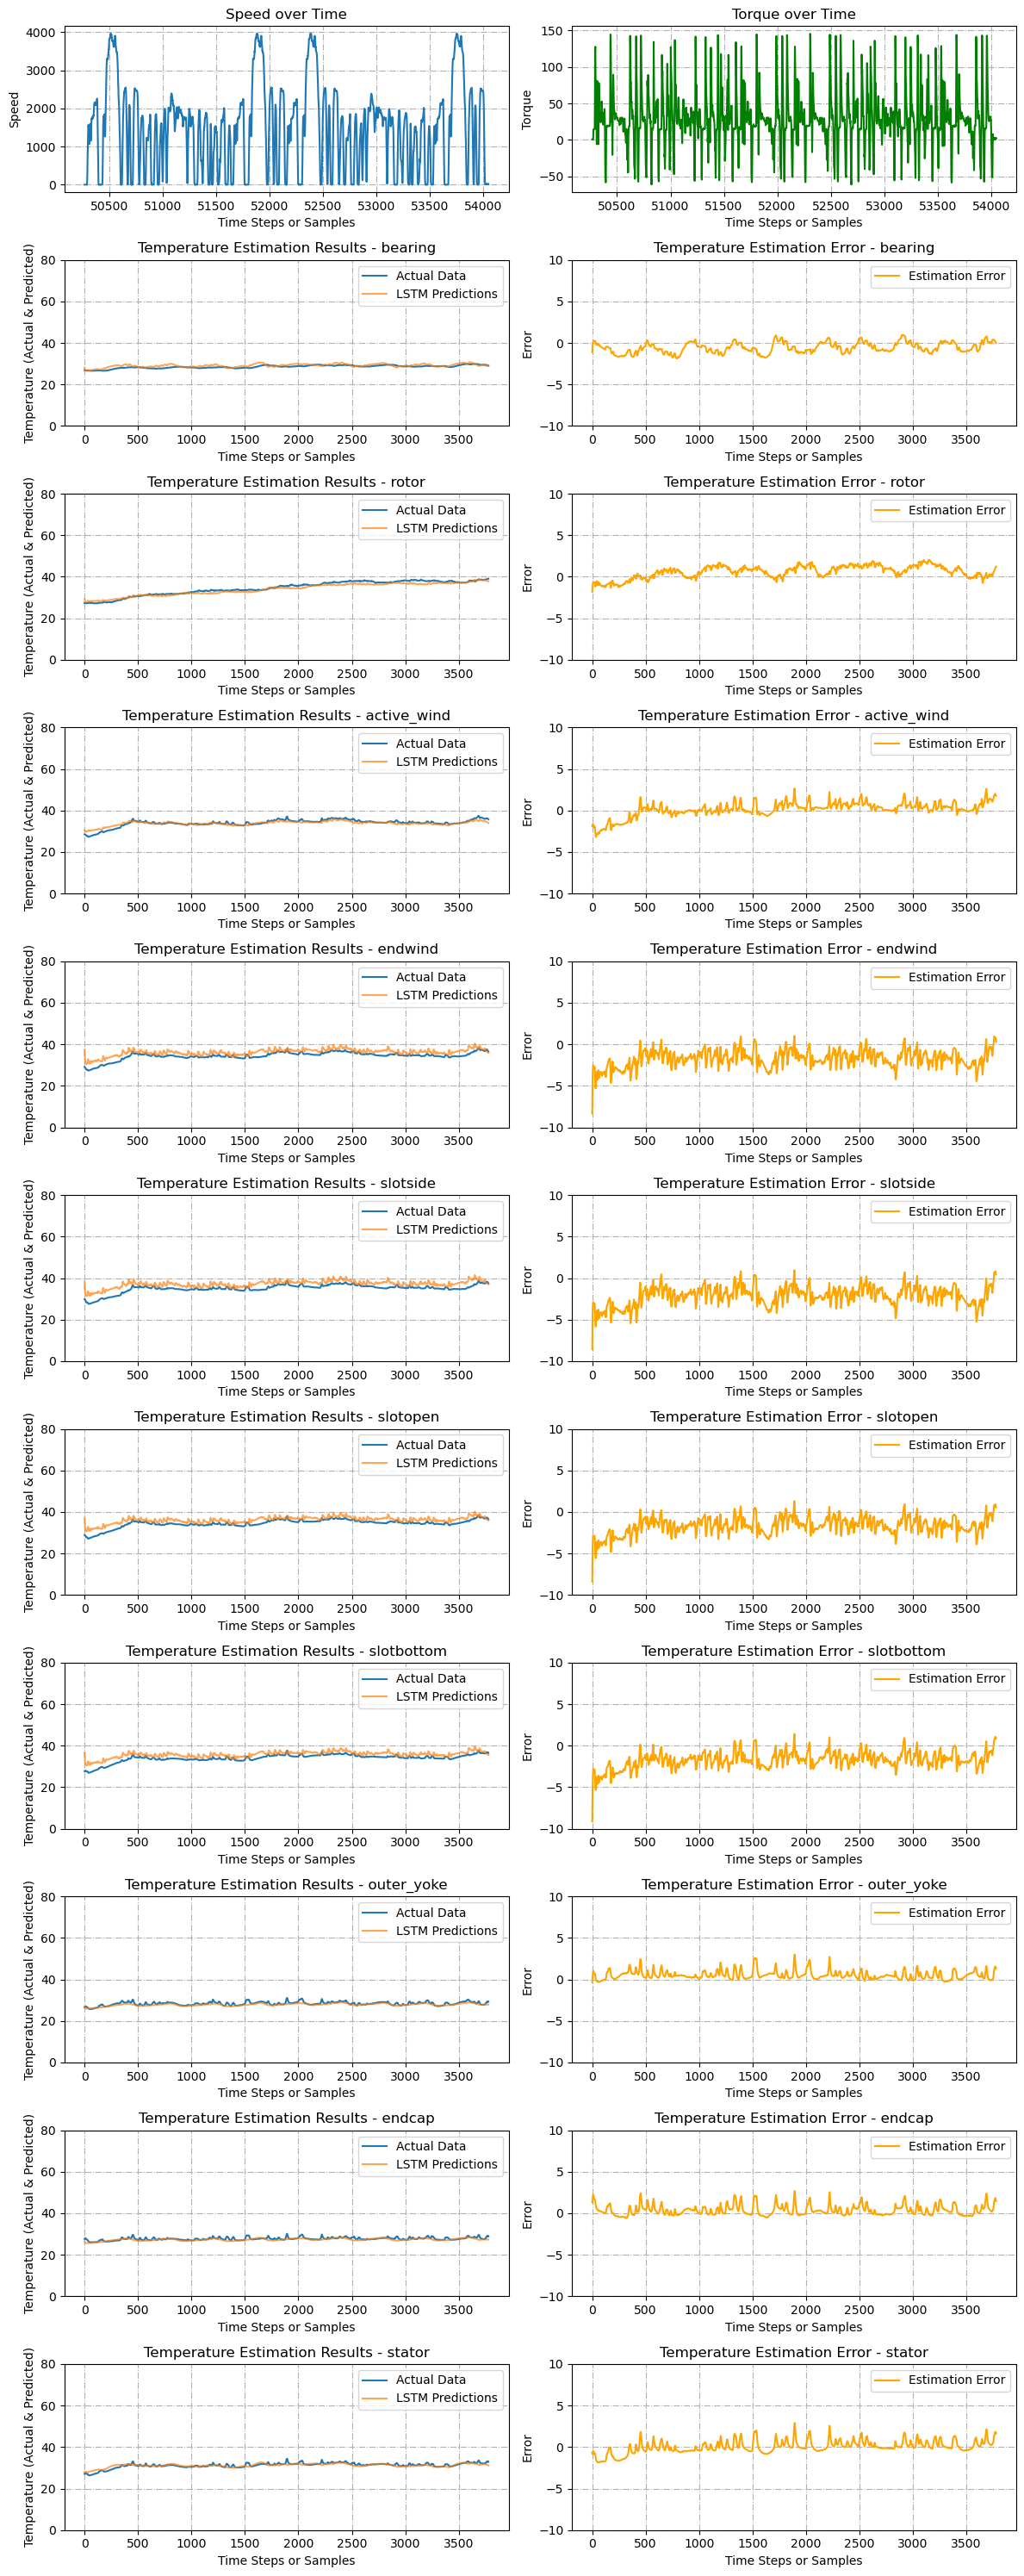

In [73]:
model.eval()  # Set the model to evaluation mode

# Create a DataLoader for the test dataset
# test_dataset  = CustomLSTMDataset(df_norm, test_profiles, inputs_cols, target_cols,device)
test_id = 6
test_dataset  = CustomLSTMDataset(df_norm, [test_id], inputs_cols, target_cols,device)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

# Store predictions and actual values
all_predictions = []
all_targets = []

with torch.no_grad():  # No need to track gradients during evaluation
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        lengths = torch.tensor([len(input) for input in inputs])
        # Forward pass to get outputs
        outputs = model(inputs,lengths)

        # # Store predictions and actual values
        # all_predictions.extend(outputs.cpu().numpy())
        # all_targets.extend(targets.cpu().numpy())
import numpy as np

# Convert lists to numpy arrays and reshape if necessary
all_inputs = inputs.cpu().numpy()
all_predictions = outputs.cpu().numpy()
all_targets = targets.cpu().numpy()

# Create a figure with 11 rows and 2 columns of subplots
fig, axs = plt.subplots(11, 2, figsize=(12, 30))  # Adjust figsize as needed
df_test = df[df["id"]==test_id].copy()
# First Row: Speed and Torque
axs[0, 0].plot(df_test['speed'], label='Speed')
axs[0, 0].set_title('Speed over Time')
axs[0, 0].set_xlabel('Time Steps or Samples')
axs[0, 0].set_ylabel('Speed')
axs[0, 0].grid(linestyle='-.')

axs[0, 1].plot(df_test['Torque'], label='Torque', color='green')
axs[0, 1].set_title('Torque over Time')
axs[0, 1].set_xlabel('Time Steps or Samples')
axs[0, 1].set_ylabel('Torque')
axs[0, 1].grid(linestyle='-.')

# Iterate over each target for the remaining rows
for i in range(10):
    # Actual Data and LSTM Predictions
    actual_data = (all_targets[0, :, i] * 0.5 + 0.5) * (global_max_target[i] - global_min_target[i]) + global_min_target[i]
    lstm_predictions = (all_predictions[0, :, i] * 0.5 + 0.5) * (global_max_target[i] - global_min_target[i]) + global_min_target[i]
    
    axs[i+1, 0].plot(actual_data, label='Actual Data')
    axs[i+1, 0].plot(lstm_predictions, label='LSTM Predictions', alpha=0.7)
    axs[i+1, 0].set_ylim([0, 80])
    axs[i+1, 0].grid(linestyle='-.')
    axs[i+1, 0].set_title(f'Temperature Estimation Results - {target_cols[i]}')
    axs[i+1, 0].set_xlabel('Time Steps or Samples')
    axs[i+1, 0].set_ylabel('Temperature (Actual & Predicted)')
    axs[i+1, 0].legend()

    # Estimation Error
    error = actual_data - lstm_predictions
    axs[i+1, 1].plot(error, label='Estimation Error', color='orange')
    axs[i+1, 1].set_ylim([-10, 10])
    axs[i+1, 1].grid(linestyle='-.')
    axs[i+1, 1].set_title(f'Temperature Estimation Error - {target_cols[i]}')
    axs[i+1, 1].set_xlabel('Time Steps or Samples')
    axs[i+1, 1].set_ylabel('Error')
    axs[i+1, 1].legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


In [ ]:
"""
This code block implements Particle Swarm Optimization (PSO) for hyperparameter tuning in a machine learning model, utilizing K-fold cross-validation to ensure robust evaluation. 

Important Notes:
- Hardware Requirements: The code is optimized for execution on a GPU and was specifically tested on an RTX2060 GPU. Ensure your system has a compatible GPU for efficient performance.
- Execution Time: The estimated runtime of this PSO search on the specified hardware is approximately 11.5 hours. 
                  This extended runtime is due to the computational complexity of both the PSO algorithm and the K-fold cross-validation process.
- Pre-Execution Check: Before initiating the PSO search, please confirm that the extended runtime is acceptable and that your system meets the necessary hardware requirements. 
                       It is advisable to run such long-duration tasks on a dedicated machine to avoid disruptions.

The use of PSO for hyperparameter tuning aims to find an optimal set of parameters for the machine learning model, potentially enhancing its performance. 
However, the effectiveness and efficiency of the search process are highly dependent on the specific configuration of the PSO algorithm, including the number of particles, 
iterations, and the defined search space for the hyperparameters.
"""


def init_model(hidden_dim, num_layers,dropout_rate):
    input_dim = 8  # Number of input features
    output_dim = 10  # Number of output features
    return LSTMModel(input_dim, hidden_dim, output_dim, num_layers,dropout_rate).to(device)

def init_optimizer(model, initial_lr, lambda_reg):
    return torch.optim.NAdam(model.parameters(), lr=initial_lr, weight_decay=lambda_reg)

def init_scheduler(optimizer, lr_decay_factor):
    return torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=lr_decay_factor)

# def train_validate_model(init_model, init_optimizer, init_scheduler, data, epochs, batch_size):
# def train_validate_model(model, optimizer, scheduler, data, epochs, batch_size):
def train_validate_model(data, epochs, batch_size, hidden_dim, num_layers, initial_lr, lr_decay_factor, lambda2_reg,dropout_rate):
    criterion = nn.MSELoss()
    kf = KFold(n_splits=5, shuffle=True)
    total_val_loss = 0

    for fold, (train_ids, valid_ids) in enumerate(kf.split(data)):
        # print(f"Training on fold {fold+1}/{n_splits}")
        # print(f"train_ids: {train_ids} valid_ids: {valid_ids}")
        train_subdataset = [data[p] for p in train_ids]
        train_loader = DataLoader(dataset = train_subdataset,batch_size = batch_size,shuffle = False,num_workers=0,collate_fn=collate_fn)

        valid_subdataset = [data[p] for p in valid_ids]
        valid_loader = DataLoader(dataset = valid_subdataset,batch_size = 1,shuffle = True,num_workers=0,collate_fn=collate_fn)
        model = init_model(hidden_dim, num_layers,dropout_rate)
        optimizer = init_optimizer(model, initial_lr, lambda2_reg)
        scheduler = init_scheduler(optimizer, lr_decay_factor)
        for epoch in range(epochs):
            model.train()
            for idx, (inputs, targets, lengths) in enumerate(train_loader):
                # print(f"Inputs shape: {inputs.shape}, Lengths: {lengths}")
                # Forward pass
                outputs = model(inputs, lengths)
                # Compute the loss
                loss = criterion(outputs, targets)
                # epoch_loss += loss.item()

                # Backward pass and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            scheduler.step()

            model.eval()
            val_loss = 0
            with torch.no_grad():
                for idx, (inputs, targets, lengths) in enumerate(valid_loader):
                    outputs = model(inputs, lengths)
                    val_loss += criterion(outputs, targets).item()
            total_val_loss += val_loss / len(valid_loader)
    avg_val_loss = total_val_loss / kf.get_n_splits()
    return avg_val_loss

def objective_function(hyperparams):
    input_dim = 8  # Number of input features
    # hidden_dim = 32  # Number of hidden layers
    output_dim = 10  # Number of output features
    hidden_dim, num_layers = int(hyperparams[0][0]), int(hyperparams[0][1])
    initial_lr, lr_decay_factor, lambda2_reg = hyperparams[0][2], hyperparams[0][3], hyperparams[0][4]
     
    batch_size = int(hyperparams[0][5])
    dropout_rate = hyperparams[0][6]
    epochs = 100

    model = LSTMModel(input_dim, hidden_dim, output_dim, num_layers,dropout_rate).to(device)
    optimizer = torch.optim.NAdam(model.parameters(), lr=initial_lr, weight_decay=lambda2_reg)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=lr_decay_factor)

    avg_val_loss = train_validate_model(train_dataset, epochs, batch_size, hidden_dim, num_layers, initial_lr, lr_decay_factor, lambda2_reg,dropout_rate)
    return avg_val_loss
# Bounds setup
bounds_list = [(16, 128),            # hidden_dim
               (1, 4),               # num_layers
               (0.0001, 0.01),       # initial_lr
               (0.85, 0.99),         # lr_decay_factor
               (0.00000001, 0.01),   # lambda_reg (L2 regularization rate)
               (1, 7),               # batch_size
               (0, 0.5)]             # dropout rate

# Convert bounds to numpy arrays
lower_bounds = np.array([bound[0] for bound in bounds_list])
upper_bounds = np.array([bound[1] for bound in bounds_list])

# Combine into a tuple
bounds = (lower_bounds, upper_bounds)

# PSO options
options = {'c1': 1.5, 'c2': 1.3, 'w': 0.9}

# Initialize PSO optimizer
optimizer_pso = pso.single.GlobalBestPSO(n_particles=30, dimensions=7, bounds=bounds, options=options)

# Perform optimization
cost, pos = optimizer_pso.optimize(objective_function, iters=100)

# Extract best hyperparameters
best_hidden_dim, best_num_layers, best_initial_lr, best_lr_decay_factor, best_lambda_reg, best_batch_size, best_dropoutrate = pos